In [72]:
import io
import fitz
import re
from PIL import Image, ImageDraw, ImageFont, ImageColor
import operator
import os
import pandas as pd 
import numpy as np
from datetime import datetime
import math
from tqdm import tqdm

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

In [3]:
"""INDEX 1"""
pdf_dir = "../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 1.pdf"
doc = fitz.open(pdf_dir)
pages = [doc[i] for i in range(doc.page_count)]
"""INDEX 1"""

TARGET_DPI = 300
mat = fitz.Matrix(TARGET_DPI/ 72, TARGET_DPI/ 72)

indent_groups = []
indent_err = 15

In [38]:
page_num = 100
pix_map = doc.get_page_pixmap(page_num,matrix=mat)
image = Image.open(io.BytesIO(pix_map.tobytes()))
draw = ImageDraw.Draw(image)
image;

In [39]:
block_lst = pages[page_num].get_text("dict")['blocks']
block_lst;

In [47]:
blank_im = Image.new('RGB', image.size, (255, 255, 255))
blank_draw = ImageDraw.Draw(blank_im)
dy_block_lst = []
x0, y0, x1, y1 = 0, 0, 0, 0
myFont = ImageFont.truetype("Arial", 15)
g_i = 0
#block_lst = dict(block_lst)
for b in block_lst:
    if b['type'] == 0:
        prev_x0, prev_y0, prev_x1, prev_y1 = x0, y0, x1, y1
        x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in b['bbox']]
        print(y0, prev_y1)
        draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"), width = 1)
        dy = y0 - prev_y1
        dy_block_lst.append(dy)
        blank_draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"), width = 1)
        blank_draw.text((20, prev_y1), str(dy), font=myFont, fill =(255, 0, 0))
        draw.text((20, prev_y1), str(dy), font=myFont, fill =(255, 0, 0))
        
        b['block_group'] = g_i
        if prev_y1 == 0 or dy > 15:
            g_i += 1

        blank_draw.text((prev_x1, prev_y1), str(b['block_group']), font=myFont, fill =(0, 0, 255))
        draw.text((prev_x1, prev_y1), str(b['block_group']), font=myFont, fill =(0, 0, 255))
        

72.87495930989583 0
167.62491861979166 110.37495930989583
220.74991861979166 213.458251953125
267.6249186197917 262.4165852864583
367.6249186197917 363.458251953125
420.7499186197917 413.458251953125
516.7499542236328 517.4166361490885
569.7499593098959 558.4166208902994
623.7500508626302 611.4166259765625
662.749989827474 665.4167175292969
754.6249389648438 704.4166564941406
804.6249389648438 800.4582722981771
854.6249389648438 850.4582722981771
1004.6249389648438 1000.4582722981771
1057.7499389648438 1050.458272298177
1151.7500559488933 1153.4166971842449
1205.750020345052 1193.4167226155598
1245.7500457763672 1247.4166870117188
1298.7500508626301 1287.416712443034
1338.7499491373699 1340.4167175292969
1604.6249389648438 1540.4167175292969
1687.624994913737 1650.458272298177
1736.6249084472656 1733.4583282470703
1785.6249491373699 1782.4582417805989
1834.6249898274739 1831.4582824707031
1914.6250406901042 1880.4583231608074
1963.6250813802083 1960.4583740234375
2012.624994913737 2009

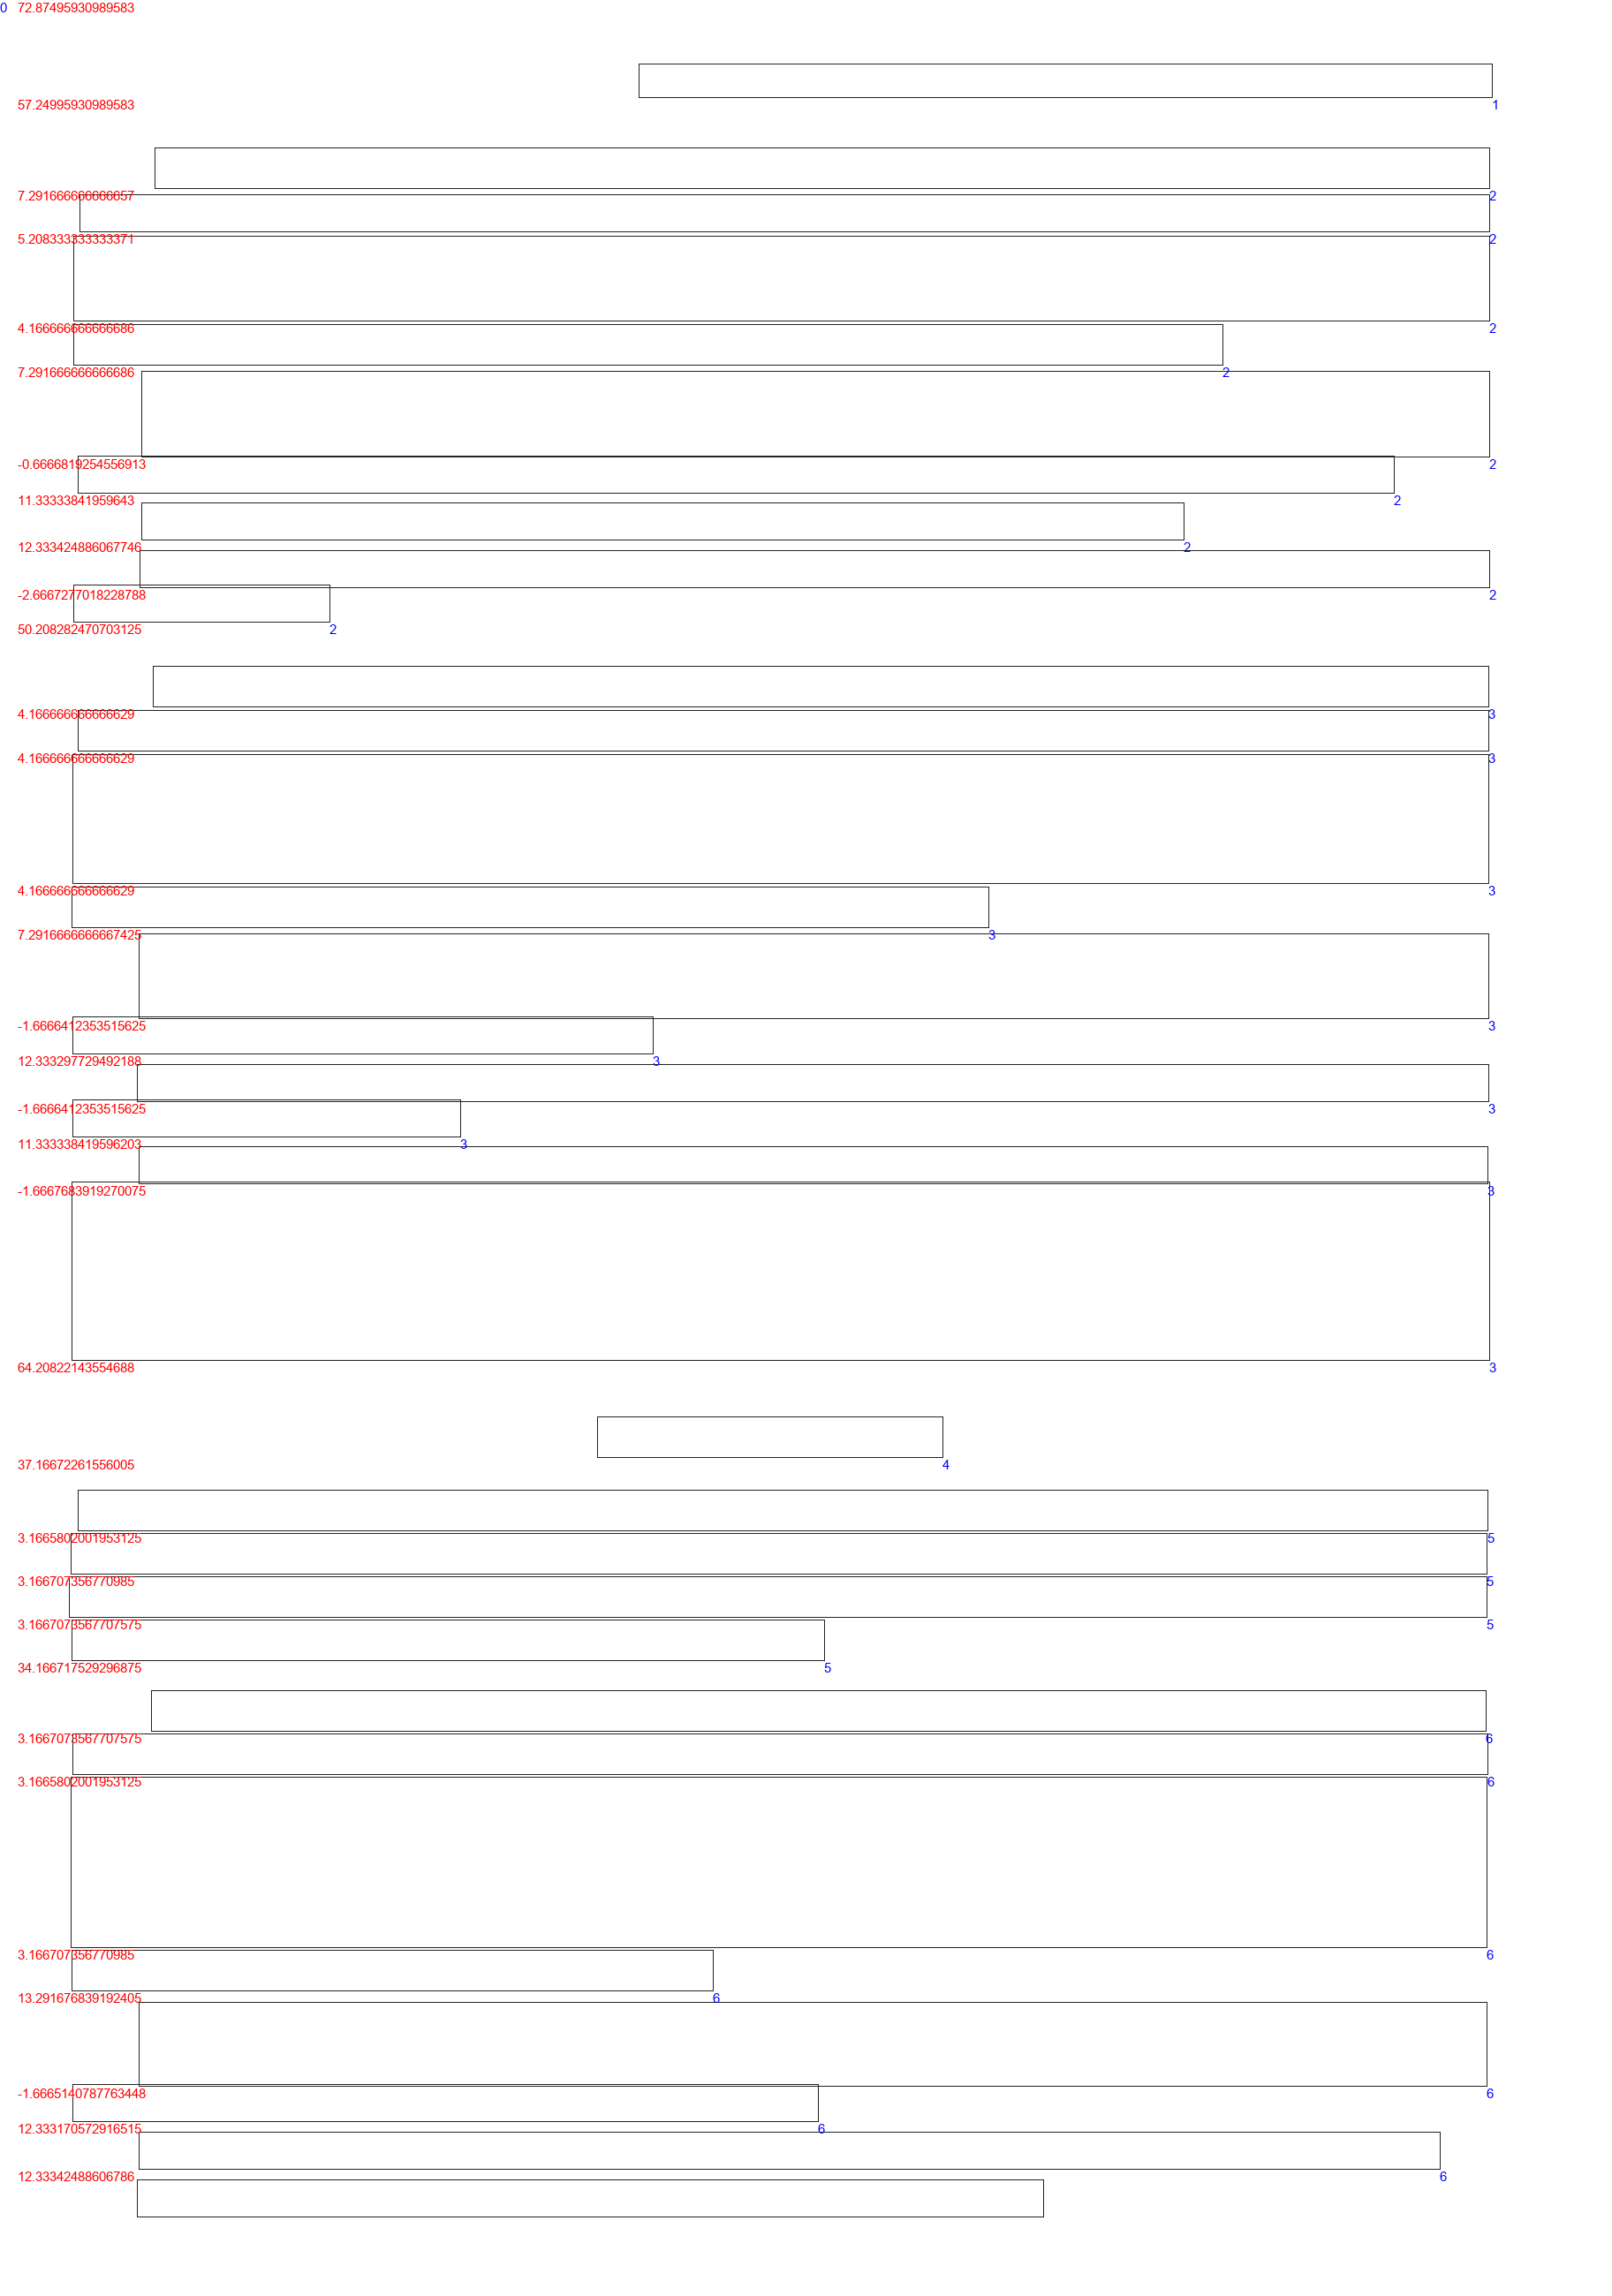

In [48]:
blank_im

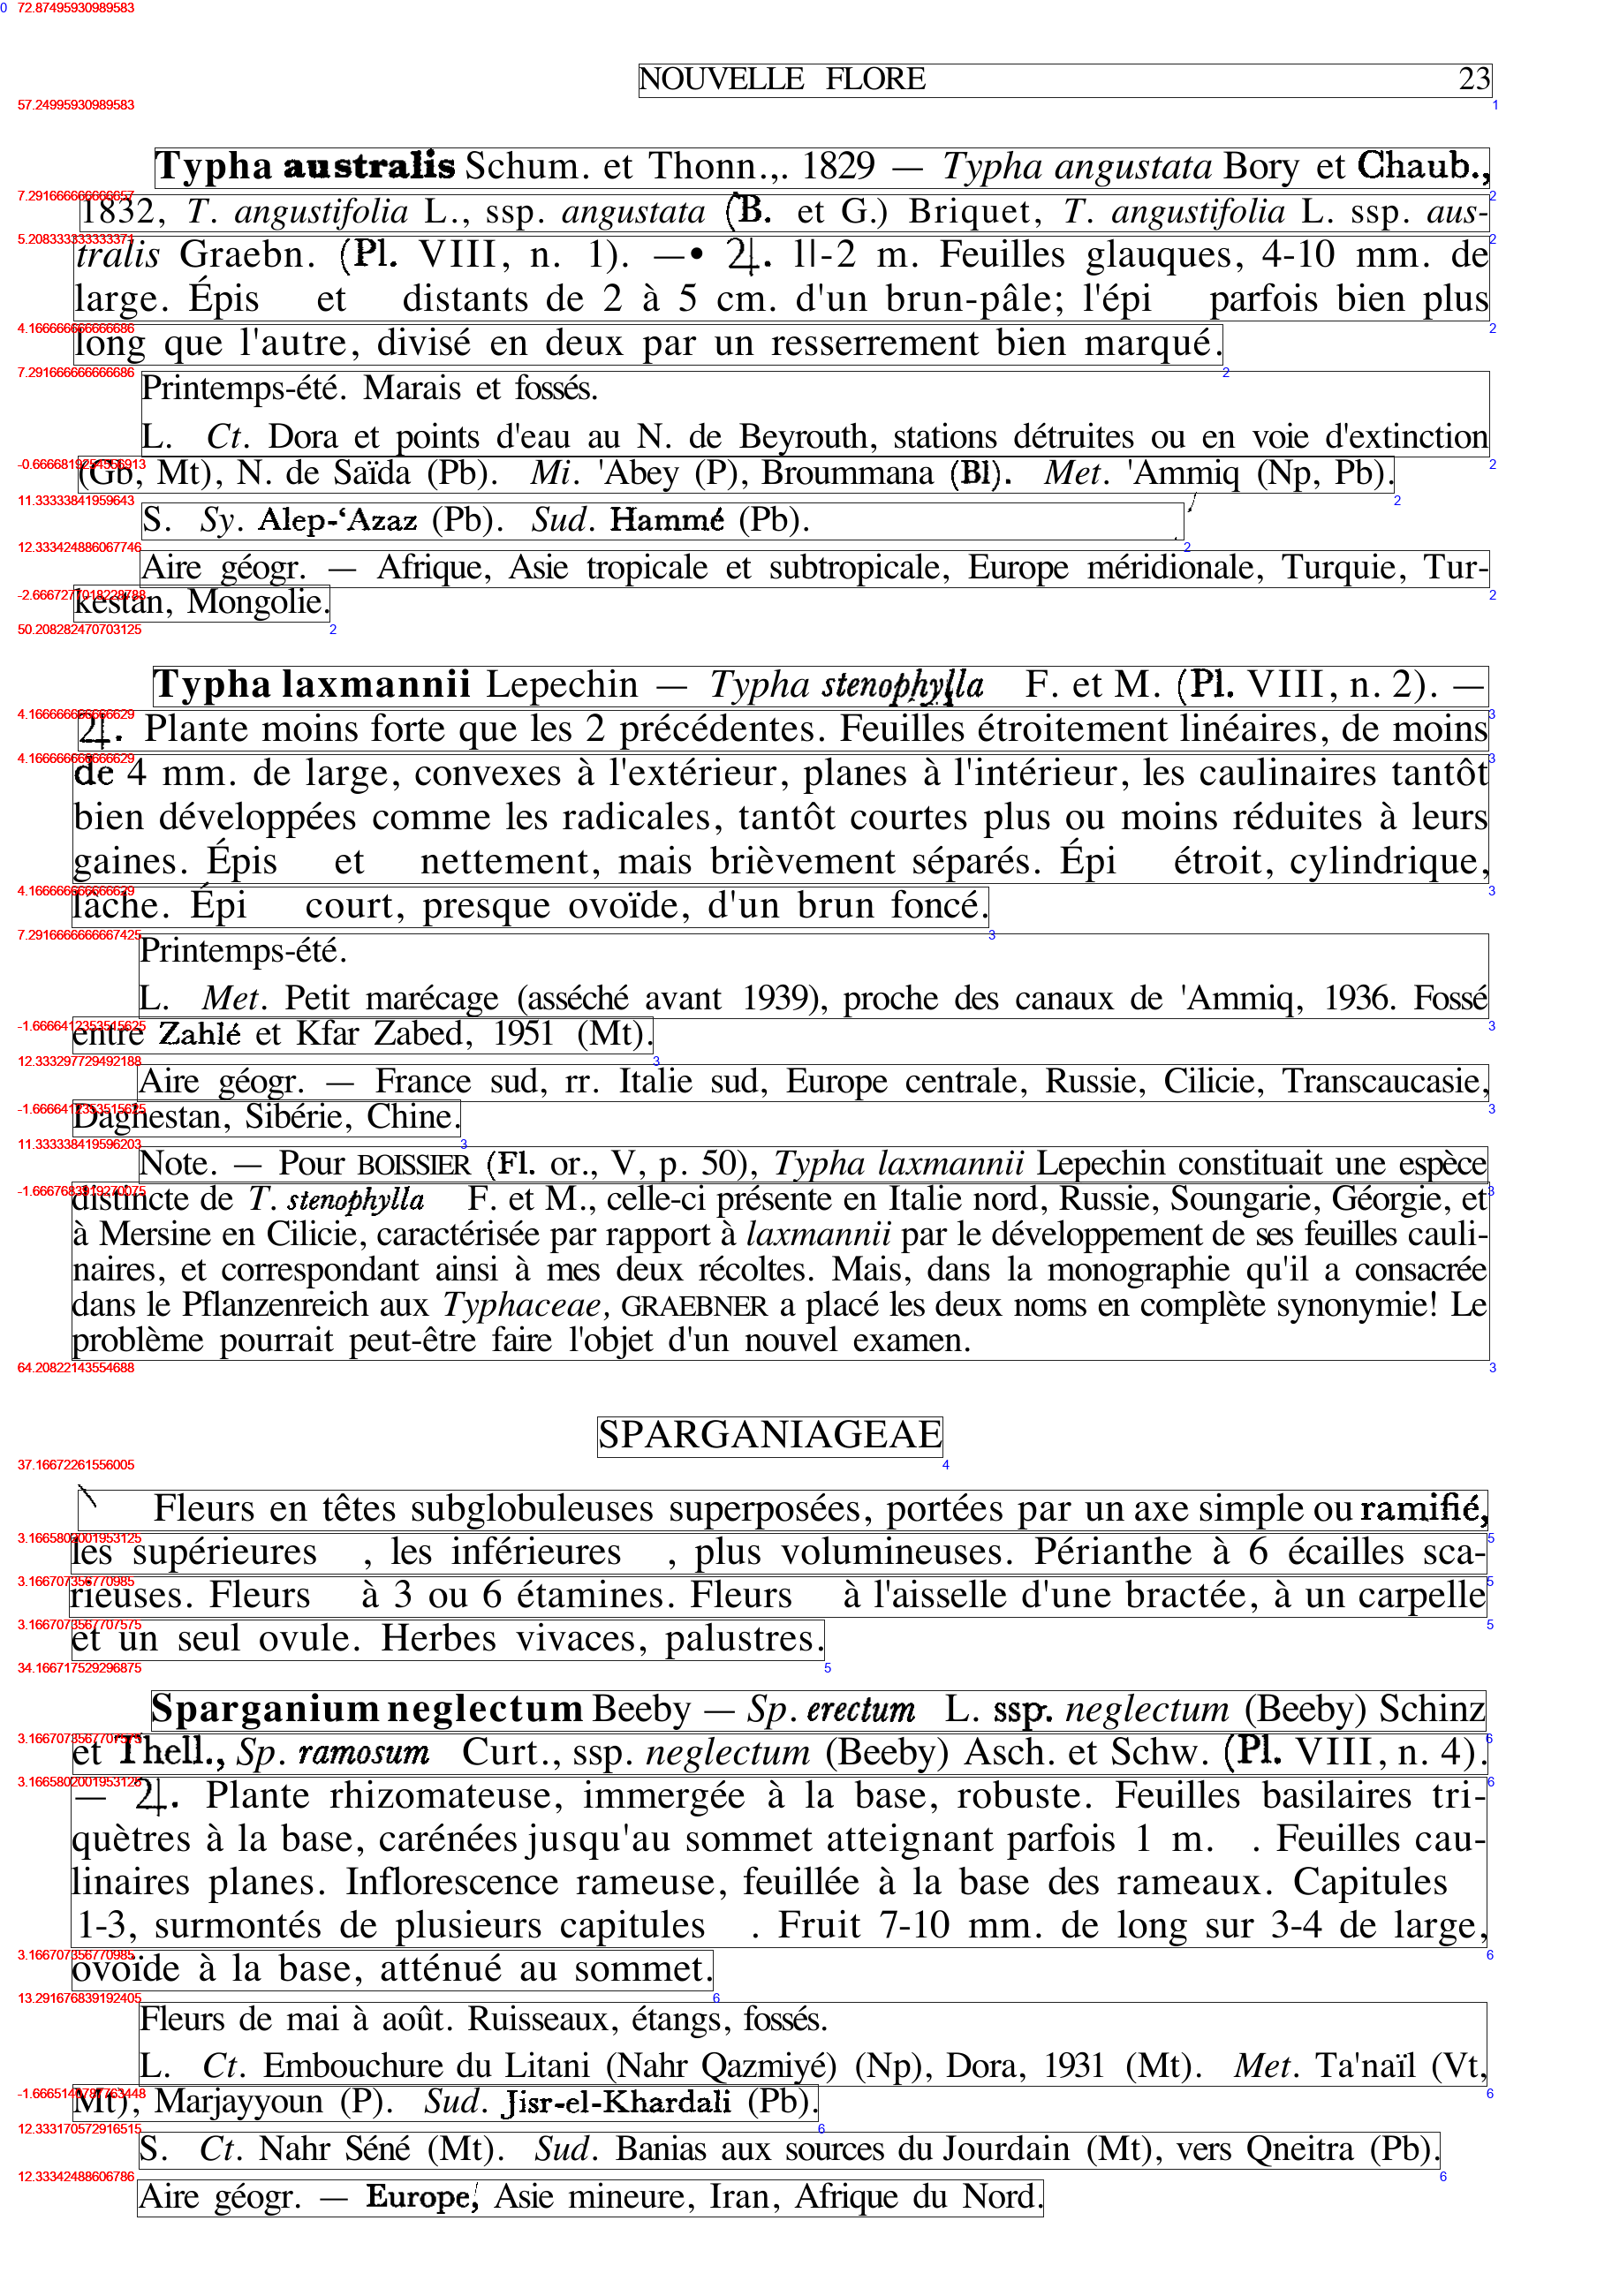

In [49]:
image

In [77]:
colors21 = ['#800000', '#e6194B', '#fabed4', 
            '#9A6324', '#f58231', '#ffd8b1', '#fffac8', '#ffe119',
            '#808000', '#bfef45', '#3cb44b', '#aaffc3', '#469990',
            '#42d4f4', '#4363d8', '#000075',
            '#911eb4', '#dcbeff', '#f032e6', 
            '#a9a9a9', '#000000']

colors7 = ['#ff0000', '#ffa500', '#ffff00', '#008000', '#0000ff', '#4b0082', '#ee82ee']

In [85]:
pix_map = doc.get_page_pixmap(page_num,matrix=mat)
image = Image.open(io.BytesIO(pix_map.tobytes()))
blank_im = Image.new('RGB', image.size, (255, 255, 255))
blank_draw = ImageDraw.Draw(blank_im)
draw = ImageDraw.Draw(image)
myFont = ImageFont.truetype("Arial", 15)

def group_blocks(block_lst, dy_threshold = 16):
    x0, y0, x1, y1 = 0, 0, 0, 0
    g_i = -1 #just because we will definitly add 1 to g_1 as prev_y1 will start at 0 first
    for b in block_lst:
        if b['type'] == 0:
            prev_x0, prev_y0, prev_x1, prev_y1 = x0, y0, x1, y1
            x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in b['bbox']]
            #print(y0, prev_y1)
            #draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"), width = 1)
            dy = y0 - prev_y1
            #dy_block_lst.append(dy)
            #blank_draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb("#222222"), width = 1)
            #blank_draw.text((20, prev_y1), str(dy), font=myFont, fill =(255, 0, 0))
            #draw.text((20, prev_y1), str(dy), font=myFont, fill =(255, 0, 0))
        
            if prev_y1 == 0 or dy > dy_threshold:
                g_i += 1

            b['block_group'] = g_i

            #blank_draw.text((prev_x1, prev_y1), str(b['block_group']), font=myFont, fill =(0, 0, 255))
            #draw.text((prev_x1, prev_y1), str(b['block_group']), font=myFont, fill =(0, 0, 255))

def draw_groups(draw, color_lst = colors7):
    for b in block_lst:
        if b['type'] == 0:
            block_no = b['block_group']
            color = color_lst[block_no%len(color_lst)]
            x0, y0, x1, y1 = [coord*TARGET_DPI/ 72 for coord in b['bbox']]
            draw.rectangle((x0, y0, x1, y1), fill=None, outline=ImageColor.getrgb(color), width = 2)

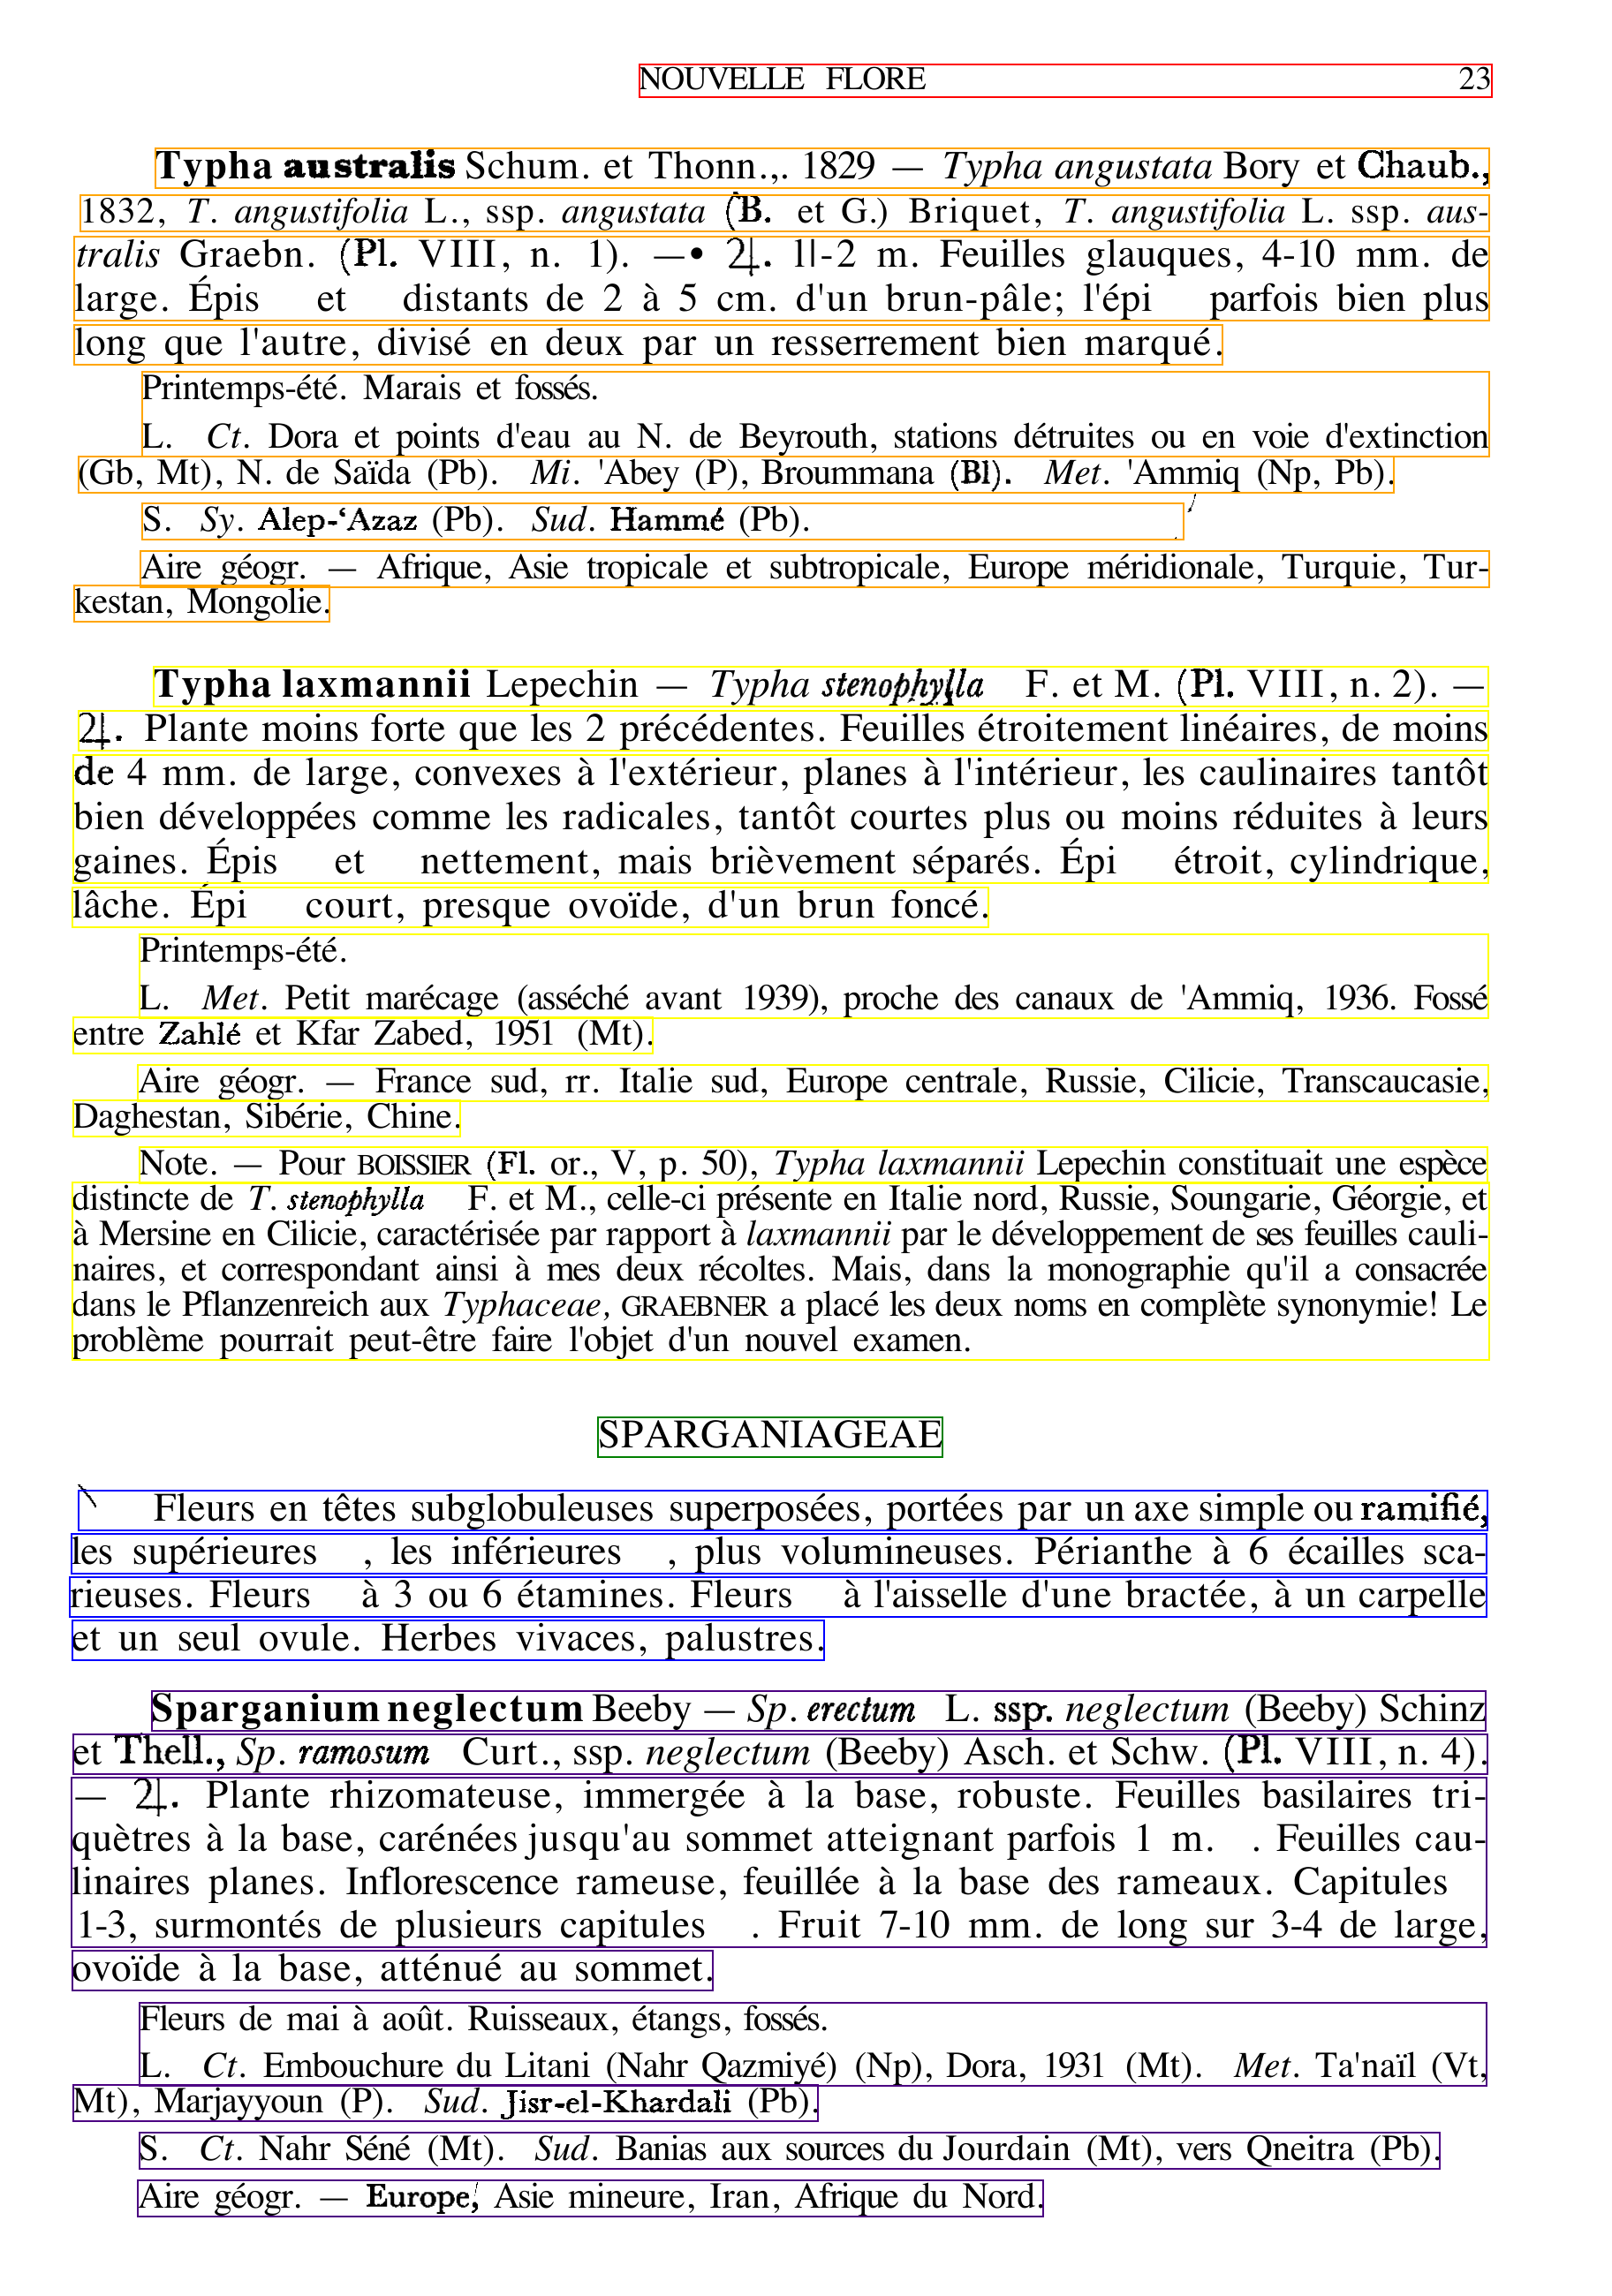

In [86]:
myFont = ImageFont.truetype("Arial", 15)

page_num = 100
block_lst = pages[page_num].get_text("dict")['blocks']
group_blocks(block_lst)

pix_map = doc.get_page_pixmap(page_num,matrix=mat)
image = Image.open(io.BytesIO(pix_map.tobytes()))
draw = ImageDraw.Draw(image)
draw_groups(draw)
image

# YAY

In [87]:
#Setting up files and directories for saving the results
SCRIPT_NAME = "block_grouping"
SCRIPT_OUTPUT_PATH = "../output/main_text/" + SCRIPT_NAME + "/"
DATE_STR = datetime.now().strftime("%Y_%m_%d") 
TIME_STR = datetime.now().strftime("%H%M")
QUICK_FIX = False
TAIL_STR = ''

if QUICK_FIX:
    OUTPUT_PATH = SCRIPT_OUTPUT_PATH + DATE_STR + "/QuickFix/" 
    #TAIL_STR = '_' + DATE_STR + '_' + TIME_STR
else:
    OUTPUT_PATH = SCRIPT_OUTPUT_PATH + DATE_STR + "/" + TIME_STR + "/"

try:
    os.makedirs(OUTPUT_PATH)
except FileExistsError:
    # directory already exists
    pass

In [90]:
result_ims = []

myFont = ImageFont.truetype("Arial", 15)

for page_num in tqdm(range(2*doc.page_count//4, 3*doc.page_count//4)):
    block_lst = pages[page_num].get_text("dict")['blocks']
    group_blocks(block_lst)
    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)
    draw_groups(draw)
    result_ims.append(image)

result_ims[0].save(OUTPUT_PATH + 'colored_blocks_3rdquarter.pdf',save_all=True, append_images=result_ims[1:])

100%|██████████| 160/160 [00:30<00:00,  5.16it/s]
